# Simulated data reconstruction (generated data)

## **Import libraries**

In [1]:
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"]="4,5,6,7"
os.chdir('..')
from parameters import *
from PtyINR.train import *
import matplotlib.pyplot as plt
from PtyINR.data_simulation_and_evaluation import*

In [2]:
os.getcwd()

'/home/tyli/github/PtyINR-main-use'

## **Load ground truth object and probe**

In [3]:
def recenter_probe(probe):

    center=int(probe.shape[0]/2)
    max_index=(probe.abs()==torch.max(probe.abs())).nonzero()
    shift=(center-max_index[0,0],center-max_index[0,1])
    recentered_probe = torch.roll(probe, shifts=tuple(shift), dims=(0, 1))

    return recentered_probe

In [4]:
crystal=np.load("data/tungsten_sample.npy")[303:,303:]

In [5]:
crystal.shape

(241, 241)

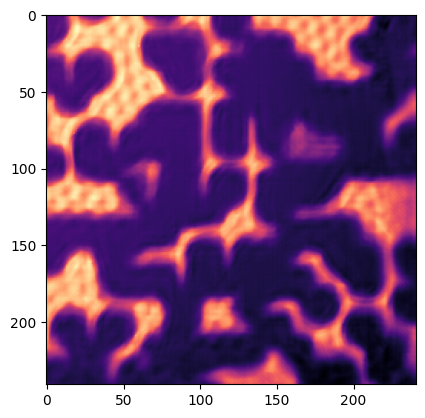

In [6]:
plt.imshow(np.angle(crystal),cmap="magma_r")

In [7]:
probe=np.load("data/probe_for_sim.npy")

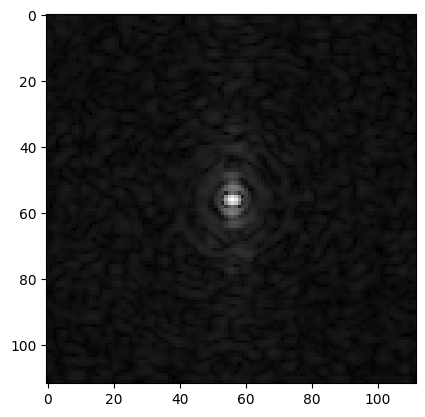

In [8]:
plt.imshow(np.sqrt(np.abs(probe)),cmap="grey")

In [9]:
np.abs(probe).flatten()

array([ 5.3614457 ,  2.53449369,  7.30203089, ..., 13.67389213,
        5.65076039,  1.75601739])

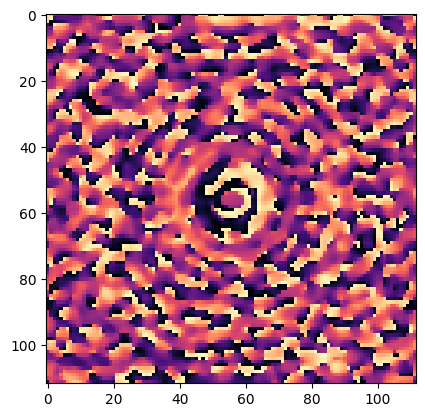

In [10]:
plt.imshow(np.angle(probe),cmap="magma")

## **Crop the central part of the real probe, make it to be 64*64**

In [11]:
probe=torch.tensor(probe).cuda()[24:-24,24:-24]

## **Overlap ratio and noise level define**

In [12]:
overlap=0.95       #choose between 0.95 0.5 0.3, for simplicity of calculation, we use illumination overlap ratio (1-step_size/probe_array_size) here, corresponding to 40%, -540%, -800% actual probe overlap ratios (1-step_size/probe_size)
noise_tag="clean"         #choose between clean, gaussian, poisson, combined
parameters["probe_known"]=False
probe_tag="probe_unknown"   # the final reconstruction will be saved with this tag

In [13]:
parameters["overlap_ratio"]=overlap
step_size=round((1-parameters["overlap_ratio"])*probe.shape[0])

pad_number=step_size-(241-probe.shape[0])%step_size

if pad_number!=step_size:
    pad=nn.ZeroPad2d((0, pad_number, 0, pad_number))
    case_obj=torch.tensor(crystal)
    case_obj=pad(case_obj)
    case_obj=case_obj.numpy()
else:
    case_obj=crystal
    
if ((case_obj.shape[0]-probe.shape[0])/step_size+1)%2!=0:
    case_obj=torch.tensor(case_obj)
    pad=nn.ZeroPad2d((0, step_size, 0, step_size))
    case_obj=pad(case_obj)
    case_obj=case_obj.numpy()

print("test object shape: ",case_obj.shape)
print("overlap ratio: ",parameters["overlap_ratio"])
parameters["obj_size"]=case_obj.shape[0]

test object shape:  (241, 241)
overlap ratio:  0.95


## **Generate diffraction patterns**

In [14]:
diffraction_pattern_generate(amplitude_gt=torch.tensor(np.abs(case_obj)),phase_gt=torch.tensor(np.angle(case_obj))
                                   ,overlap_ratio=overlap,probe=probe,
                       parameters=parameters,noise=noise_tag)

step size:  3
the diffraction pattern shape is  (3600, 64, 64)


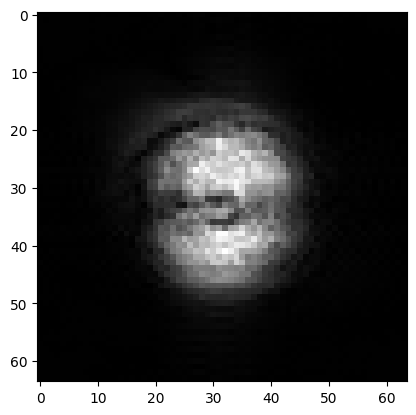

In [15]:
h5=h5py.File(parameters["real_data_source"], 'r')
plt.imshow(h5["diffamp"][()][11],cmap="grey")

## Training
You may also change hyperparameters from parameters.py

In [16]:
parameters["tag"]="tungsten_"+noise_tag+"_PtyINR_"+str(overlap)+"_"+probe_tag
parameters["total_steps"] = 6000
parameters["diffraction_scale"]=600

parameters["train_method"]="mini_batch"   
parameters["batches"]=3600
parameters["LR"]=2e-5           # for object amplitude       
parameters["LR2"]=2e-5         # for object phase 
parameters["LR3"]=1e-5           # for probe amplitude
parameters["LR4"]=1e-5         # for probe phase
parameters["regularized_loss_weight"]=1e-2     #1
parameters["regularized_steps"]=50
parameters["show_every"]=100
parameters["first_omega"]=30

parameters["loss"]="SmoothL1"
parameters["beta_for_smoothl1"]=1e-2

In [17]:
train_model(parameters)

Using stocastic gradient descent(SGD)!

Please use tensor board to see the intermediate images.
The tensor board files are stored in the folder:  result/tb
The images of latest reconstructions can be found at :  result/ 

[GPU 1] diffraction patterns shape (3600, 64, 64)
[GPU 0] diffraction patterns shape (3600, 64, 64)
[DDP] Requested global batch=3600 -> per-rank batch=900 (effective global=3600)
[GPU 2] diffraction patterns shape (3600, 64, 64)
[GPU 3] diffraction patterns shape (3600, 64, 64)
using SmoothL1 loss for training!
[GPU 0] Step 0, global accumulated loss: 143.541652
[GPU 0] Step 100, global accumulated loss: 5.639650
[GPU 0] Step 200, global accumulated loss: 0.895525
[GPU 0] Step 300, global accumulated loss: 0.550343
[GPU 0] Step 400, global accumulated loss: 0.398064
[GPU 0] Step 500, global accumulated loss: 0.293712
[GPU 0] Step 600, global accumulated loss: 0.210430
[GPU 0] Step 700, global accumulated loss: 0.149313
[GPU 0] Step 800, global accumulated loss: 0.103

## Evaluation of the object reconstruction

In [18]:
recon_obj= np.load("result/tungsten_clean_PtyINR_0.95_probe_unknown_obj.npy")  
ground_truth=np.load("data/tungsten_sample.npy")
recon_obj_evaluation(recon_obj,ground_truth)

Reconstructed object amplitude and phase in PSNR/SSIM: 64.5/1.0  28.31/0.96


## Evaluation of the probe reconstruction

In [19]:
recon_probe= np.load("result/tungsten_clean_PtyINR_0.95_probe_unknown_probe.npy")
ground_truth=np.load("data/probe_for_sim.npy")[24:-24,24:-24]
recon_probe_evaluation(recon_probe,ground_truth)

Reconstructed probe amplitude and phase in PSNR/SSIM: 70.5/1.0  17.09/0.92


## Visualization of results

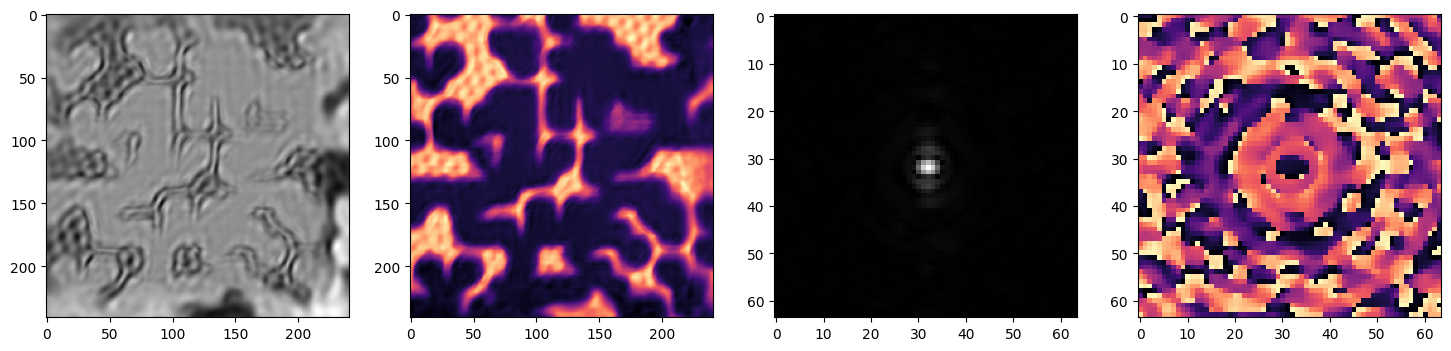

In [20]:
fig, axes = plt.subplots(1,4, figsize=(18,6))
axes[0].imshow(np.rot90(np.abs(recon_obj),k=4),cmap="grey")
axes[1].imshow(np.rot90(np.angle(recon_obj),k=4),cmap="magma_r")
axes[2].imshow(np.abs(recon_probe),cmap="grey")
axes[3].imshow(np.angle(recon_probe),cmap="magma")
plt.show()